[    0.0s | 11849.2MB] 
Loading dataset
[    5.0s | 12387.4MB] Initial shape: (555278, 88)
[    5.0s | 12387.4MB] Detected label column: Label
[    5.7s | 12430.6MB] No explicit normal token; using majority label '0' as normal.
[    5.8s | 12430.6MB] Binary label distribution:
is_attack
0    517582
1     37696
Name: count, dtype: int64
[    5.8s | 12388.8MB] Numeric feature selection -> 56 columns
[    5.8s | 12388.8MB] Starting robust clean on features...
[    6.3s | 12388.8MB] NaNs before fill: 0
[    6.8s | 12388.8MB] NaNs after fill: 0
[    7.2s | 12389.0MB] Final feature list length: 56
[    7.2s | 12389.0MB] 
Train/Test Split
[    8.0s | 12235.0MB] X_train=(416458, 56), X_test=(138820, 56)
[    8.0s | 12235.0MB] Train class distribution: [388186  28272] | Test: [129396   9424]
[    8.1s | 12015.9MB] Normal-only count for AE: 388186
[    8.9s | 11962.6MB] X_train_norm_s: shape=(388186, 56), dtype=float64, min=-2.1660, max=6.0000, mean=-0.0114, std=0.7254, NaNs=0
[    9.0s | 11914.

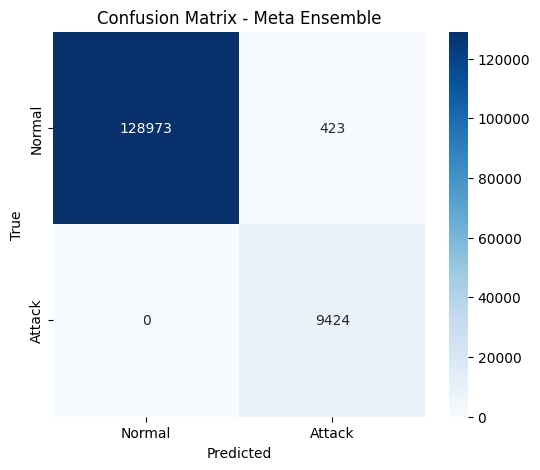

[ 1228.8s | 11586.2MB] 
Benchmark Comparison
[ 1229.0s | 11586.2MB] Final comparison table:
            Method  Accuracy  Precision  Recall    F1
        Paper (AE)     94.00      81.00    99.0 89.00
      Fernandes RF     98.00      99.00    69.0 81.00
     Fernandes XGB     96.00      99.00    44.0 61.00
      Vitorino KNN     98.00      98.00    98.0 98.00
      Vitorino MLP     90.00      90.00    90.0 89.00
Our AE per-cluster     95.29      91.58    33.8 49.37
 Our Meta Ensemble     99.70      95.70   100.0 97.80

Notes:
- Adjust PR_TARGET_PRECISION to bias threshold toward higher precision.
- Increase quantile (0.995) for cluster thresholds for stricter anomaly gating.
- ENABLE_FLOW=True may add a new signal; watch logs for stability.
- Reduce DEBUG_LEVEL to 1 or 0 for cleaner output once stable.
- Use SMALL_SAMPLE to iterate faster on large dataset.


In [14]:
"""
HIKARI-2021 Advanced Anomaly Detection (Full Debug Version)

Features:
 1. Clean robust preprocessing + per-feature scaling
 2. AE residual modeling (Mahalanobis, GMM PCA, optional Flow)
 3. Per-cluster latent thresholds
 4. Latent-space supervised calibrated classifier
 5. Ensemble (AE hybrid, GMM, IF, XGB, latent LR, optional flow) + meta logistic regression
 6. PR-based threshold selection
 7. Extensive DEBUG instrumentation (shapes, stats, timings, NaN checks)

Adjust verbosity:
  DEBUG_LEVEL: 0 (quiet), 1 (steps), 2 (detailed)
  LOG_BATCHES: per-batch AE training logs (may be noisy)
"""

# ======================
# Configuration Flags
# ======================

DEBUG_LEVEL = 2              # 0,1,2
LOG_BATCHES = False          # Per-batch logs inside AE training
CSV_PATH = "/kaggle/input/hikari-dataset/ALLFLOWMETER_HIKARI2021.csv"
SMALL_SAMPLE = None          # e.g. 300000 for quicker dev runs
N_SPLITS = 3
BATCH_SIZE = 256
EPOCHS = 60
CLIP_VALUE = 6.0
PR_TARGET_PRECISION = 0.95
KMEANS_CLUSTERS = 6
GMM_COMPONENTS = 3
PCA_RESID_DIM = 12
LATENT_DIM = 32
AE_WIDTH = 128
DROPOUT = 0.25
LEARNING_RATE = 1e-3
ISOLATION_TREES = 300
XGB_PARAMS = dict(
    n_estimators=400, max_depth=8, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    objective="binary:logistic", eval_metric="logloss", random_state=42
)

ENABLE_FLOW = False          # Normalizing flow off by default
FLOW_STEPS = 400
FLOW_LR = 3e-4
FLOW_CLIPNORM = 1.0
FLOW_HIDDEN = 64
FLOW_BIJECTORS = 4
FLOW_CLIP_INPUT = 5.0

PLOT = True

# ======================
# Imports
# ======================

import os, gc, time, psutil, math
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

try:
    import tensorflow_probability as tfp
    TFP_AVAILABLE = True
    tfd = tfp.distributions
    tfb = tfp.bijectors
except Exception:
    TFP_AVAILABLE = False

np.random.seed(42)
tf.random.set_seed(42)

# ======================
# Debug Utilities
# ======================

START_TIME = time.time()

def mem_usage_mb():
    return psutil.Process(os.getpid()).memory_info().rss / (1024**2)

def dbg(msg, level=1):
    if DEBUG_LEVEL >= level:
        elapsed = time.time() - START_TIME
        print(f"[{elapsed:7.1f}s | {mem_usage_mb():7.1f}MB] {msg}")

def banner(title):
    line = "=" * min(100, max(30, len(title)+10))
    dbg(f"\n{line}\n{title}\n{line}", level=1)

def stats_vector(name, arr, level=2):
    if DEBUG_LEVEL >= level:
        if arr is None:
            dbg(f"{name}: None", level)
            return
        dbg(f"{name}: shape={arr.shape}, dtype={arr.dtype}, "
            f"min={np.nanmin(arr):.4f}, max={np.nanmax(arr):.4f}, "
            f"mean={np.nanmean(arr):.4f}, std={np.nanstd(arr):.4f}, "
            f"NaNs={np.isnan(arr).sum()}")

# ======================
# Helper Functions
# ======================

def detect_label_column(df: pd.DataFrame) -> str:
    candidates = ['label', 'Label', 'LABEL', 'class', 'Class', 'attack', 'Attack', 'type', 'Type', 'TYPE']
    for c in candidates:
        if c in df.columns:
            return c
    for c in df.columns:
        if any(k in c.lower() for k in ['label','class','attack','type']):
            return c
    return df.columns[-1]

def make_binary_labels(df: pd.DataFrame, label_col: str) -> pd.Series:
    if label_col != 'label':
        df.rename(columns={label_col: 'label'}, inplace=True)
    s = df['label'].astype(str).str.lower().str.strip()
    normal_keywords = ['normal','benign','legitimate','background']
    is_normal = None
    for kw in normal_keywords:
        if s.str.contains(kw).any():
            is_normal = s.str.contains(kw)
            dbg(f"Detected normal keyword: {kw}")
            break
    if is_normal is None:
        maj = df['label'].value_counts().idxmax()
        dbg(f"No explicit normal token; using majority label '{maj}' as normal.")
        is_normal = (df['label'] == maj)
    return (~is_normal).astype(int)

def select_numeric_features(df: pd.DataFrame) -> list:
    exclude_patterns = ['label','ip','port','time','mac','src','dst','flow','address','id']
    exclude_cols = set(['label','is_attack'])
    for col in df.columns:
        lc = col.lower()
        if any(p in lc for p in exclude_patterns):
            exclude_cols.add(col)
        if df[col].dtype not in [np.int16,np.int32,np.int64,np.float16,np.float32,np.float64]:
            exclude_cols.add(col)
    feats = [c for c in df.columns if c not in exclude_cols]
    dbg(f"Numeric feature selection -> {len(feats)} columns")
    return feats

def robust_clean(df: pd.DataFrame, features: list) -> list:
    dbg("Starting robust clean on features...")
    df[features] = df[features].replace([np.inf,-np.inf], np.nan)
    nan_before = df[features].isna().sum().sum()
    dbg(f"NaNs before fill: {nan_before}")
    for c in features:
        med = df[c].median()
        if pd.isna(med):
            med = 0.0
        df[c] = df[c].fillna(med)
    nan_after = df[features].isna().sum().sum()
    dbg(f"NaNs after fill: {nan_after}")
    const = [c for c in features if df[c].nunique() <= 1]
    if const:
        dbg(f"Removing {len(const)} constant features: {const[:10]}{'...' if len(const)>10 else ''}")
        features = [c for c in features if c not in const]
    return features

class DebugTrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        dbg("AE training started", 1)
    def on_epoch_end(self, epoch, logs=None):
        dbg(f"Epoch {epoch+1:03d}/{EPOCHS} "
            f"loss={logs.get('loss'):.6f} val_loss={logs.get('val_loss'):.6f} "
            f"mae={logs.get('mae'):.6f} val_mae={logs.get('val_mae'):.6f}", 2)
    def on_train_end(self, logs=None):
        dbg("AE training finished", 1)
    def on_batch_end(self, batch, logs=None):
        if LOG_BATCHES:
            dbg(f"  Batch {batch} loss={logs.get('loss'):.6f}", 2)

def build_autoencoder(input_dim: int, latent_dim: int = LATENT_DIM, width: int = AE_WIDTH, dropout: float = DROPOUT):
    dbg(f"Building AE (input_dim={input_dim}, latent_dim={latent_dim}, width={width}, dropout={dropout})", 1)
    inp = Input(shape=(input_dim,), name="ae_input")
    x = layers.Dense(width, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(latent_dim, activation='relu', name="latent")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(width, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(input_dim, activation='linear')(x)
    ae = Model(inp, out, name="Autoencoder")
    enc = Model(inp, ae.get_layer('latent').output, name="Encoder")
    dbg("AE built successfully.", 1)
    return ae, enc

def fit_gmm_on_residuals(residuals: np.ndarray, pca_dim: int = PCA_RESID_DIM, n_components: int = GMM_COMPONENTS):
    dbg(f"Fitting GMM: residuals shape={residuals.shape}, PCA_dim={pca_dim}, components={n_components}", 1)
    pca_dim_eff = min(pca_dim, max(2, residuals.shape[1]-1))
    pca = PCA(n_components=pca_dim_eff, random_state=42)
    Z = pca.fit_transform(residuals)
    dbg(f"PCA residuals shape: {Z.shape}", 2)
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(Z)
    dbg("GMM fitted.", 1)
    return pca, gmm

def mahalanobis_on_residuals(residuals: np.ndarray):
    dbg(f"Computing Mahalanobis parameters for residuals shape={residuals.shape}", 1)
    cov = np.cov(residuals.T)
    eps = 1e-6
    cov += np.eye(cov.shape[0]) * eps
    inv = np.linalg.inv(cov)
    mean = residuals.mean(axis=0)
    dbg("Mahalanobis prepared (cov regularized).", 2)
    def md(X):
        diff = X - mean
        return np.sqrt(np.einsum('ij,jk,ik->i', diff, inv, diff))
    return md

def pr_threshold(y_true, scores, target_precision: float = None):
    dbg("Computing PR-based threshold...", 1)
    prec, rec, thr = precision_recall_curve(y_true, scores)
    f1 = (2*prec*rec)/(prec+rec+1e-12)
    best_idx = np.nanargmax(f1)
    best_thr = thr[max(best_idx-1,0)]
    result = dict(kind="max_f1", threshold=float(best_thr),
                  precision=float(prec[best_idx]), recall=float(rec[best_idx]), f1=float(f1[best_idx]))
    if target_precision is None:
        dbg(f"Max-F1 threshold selected: {result}", 2)
        return result
    ok = np.where(prec[:-1] >= target_precision)[0]
    if len(ok)==0:
        dbg("Target precision not reachable; fallback to max F1", 1)
        dbg(f"Max-F1: {result}", 2)
        return result
    idx = ok[np.argmax(rec[ok])]
    result_tp = dict(kind=f"target_precision_{target_precision}",
                     threshold=float(thr[idx]),
                     precision=float(prec[idx]),
                     recall=float(rec[idx]),
                     f1=float(f1[idx]))
    dbg(f"Target-precision threshold selected: {result_tp}", 2)
    return result_tp

def evaluate_metrics(y_true, y_pred, prob_scores=None, title=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    ap = average_precision_score(y_true, prob_scores) if prob_scores is not None else np.nan
    auc = roc_auc_score(y_true, prob_scores) if prob_scores is not None else np.nan
    dbg(f"[{title}] Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f} AP={ap:.4f} AUC={auc:.4f}", 1)
    return dict(accuracy=acc, precision=prec, recall=rec, f1=f1, ap=ap, auc=auc)

# Flow utilities (robust)
def standardize_clip(X, mean=None, std=None, clip=FLOW_CLIP_INPUT):
    if mean is None:
        mean = X.mean(axis=0)
    if std is None:
        std = X.std(axis=0) + 1e-6
    Z = (X - mean) / std
    Z = np.clip(Z, -clip, clip)
    return Z, mean, std

def try_normalizing_flow(train_residuals: np.ndarray):
    if not (ENABLE_FLOW and TFP_AVAILABLE):
        dbg("Flow disabled or TFP unavailable.", 1)
        return None
    dbg("Initializing normalizing flow...", 1)
    Z, m, s = standardize_clip(train_residuals.astype(np.float32))
    dims = Z.shape[1]
    bijectors = []
    for _ in range(FLOW_BIJECTORS):
        bijectors.append(
            tfb.MaskedAutoregressiveFlow(
                shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                    params=2, hidden_units=[FLOW_HIDDEN, FLOW_HIDDEN]
                )
            )
        )
        bijectors.append(tfb.Permute(permutation=list(reversed(range(dims)))))
    flow_bijector = tfb.Chain(list(reversed(bijectors)))
    base = tfd.MultivariateNormalDiag(loc=tf.zeros(dims), scale_diag=tf.ones(dims))
    flow = tfd.TransformedDistribution(distribution=base, bijector=flow_bijector)

    x = tf.convert_to_tensor(Z, dtype=tf.float32)
    ds = tf.data.Dataset.from_tensor_slices(x).shuffle(8192, seed=42).batch(512).prefetch(tf.data.AUTOTUNE)
    opt = tf.keras.optimizers.Adam(FLOW_LR, clipnorm=FLOW_CLIPNORM)
    best = np.inf
    patience = 0
    for step, batch in enumerate(ds.repeat(), start=1):
        with tf.GradientTape() as tape:
            loss = -tf.reduce_mean(flow.log_prob(batch))
        if not tf.reduce_all(tf.math.is_finite(loss)):
            dbg(f"[Flow] Non-finite loss at step {step}, aborting flow.", 1)
            return None
        grads = tape.gradient(loss, flow.trainable_variables)
        opt.apply_gradients(zip(grads, flow.trainable_variables))
        if step % 100 == 0:
            curr = float(loss.numpy())
            dbg(f"[Flow] step {step} loss={curr:.6f}", 2)
            if curr + 1e-4 < best:
                best = curr
                patience = 0
            else:
                patience += 1
            if patience >= 5 or step >= FLOW_STEPS:
                break
    dbg("Flow training complete.", 1)
    return dict(flow=flow, mean=m.astype(np.float32), std=s.astype(np.float32))

def score_with_flow(bundle, residuals: np.ndarray):
    if bundle is None:
        return None
    Z, _, _ = standardize_clip(residuals.astype(np.float32),
                               mean=bundle['mean'], std=bundle['std'])
    flow = bundle['flow']
    ll = flow.log_prob(tf.convert_to_tensor(Z)).numpy()
    return -ll  # negative log-likelihood as anomaly score

# ======================
# Load dataset
# ======================
banner("Loading dataset")
df = pd.read_csv(CSV_PATH)
dbg(f"Initial shape: {df.shape}")

if SMALL_SAMPLE is not None and len(df) > SMALL_SAMPLE:
    df = df.sample(SMALL_SAMPLE, random_state=42).reset_index(drop=True)
    dbg(f"After sampling shape: {df.shape}")

label_col = detect_label_column(df)
dbg(f"Detected label column: {label_col}")
df['is_attack'] = make_binary_labels(df, label_col)
dbg("Binary label distribution:\n" + str(df['is_attack'].value_counts()))

feature_cols = select_numeric_features(df)
feature_cols = robust_clean(df, feature_cols)
dbg(f"Final feature list length: {len(feature_cols)}")

# ======================
# Train / Test split
# ======================
banner("Train/Test Split")
X_all = df[feature_cols].values
y_all = df['is_attack'].values
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.25, random_state=42, stratify=y_all
)
dbg(f"X_train={X_train.shape}, X_test={X_test.shape}")
dbg(f"Train class distribution: {np.bincount(y_train)} | Test: {np.bincount(y_test)}")

# AE normal-only
X_train_norm = X_train[y_train==0]
dbg(f"Normal-only count for AE: {X_train_norm.shape[0]}")

# Scalers
scaler_ae = StandardScaler()
X_train_norm_s = scaler_ae.fit_transform(X_train_norm)
X_train_norm_s = np.clip(X_train_norm_s, -CLIP_VALUE, CLIP_VALUE)
stats_vector("X_train_norm_s", X_train_norm_s)

X_tr_ae, X_val_ae = train_test_split(X_train_norm_s, test_size=0.1, random_state=42)
dbg(f"AE train subset: {X_tr_ae.shape}, AE val subset: {X_val_ae.shape}")

scaler_sup = StandardScaler()
X_train_sup_s = scaler_sup.fit_transform(X_train)
X_test_sup_s = scaler_sup.transform(X_test)
stats_vector("X_train_sup_s", X_train_sup_s, 2)

# ======================
# Cross-validation (Meta Ensemble)
# ======================
banner("Cross-Validation Meta Ensemble")
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
oof_scores = []
oof_y = []

for fold,(tr_idx,val_idx) in enumerate(skf.split(X_train,y_train), start=1):
    banner(f"Fold {fold}/{N_SPLITS}")
    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]
    dbg(f"Fold train shape={X_tr.shape}, val shape={X_val.shape}")
    dbg(f"Fold class dist train={np.bincount(y_tr)}, val={np.bincount(y_val)}")

    # Fold AE normals
    X_tr_norm = X_tr[y_tr==0]
    X_tr_norm_s = scaler_ae.fit_transform(X_tr_norm)
    X_tr_norm_s = np.clip(X_tr_norm_s, -CLIP_VALUE, CLIP_VALUE)
    X_tr_ae_f, X_v_ae_f = train_test_split(X_tr_norm_s, test_size=0.1, random_state=42)
    dbg(f"Fold AE normal train={X_tr_ae_f.shape}, normal val={X_v_ae_f.shape}")

    # Build AE
    ae, encoder = build_autoencoder(X_tr_norm_s.shape[1], LATENT_DIM, AE_WIDTH, DROPOUT)
    ae.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE, clipnorm=1.0),
               loss='mse', metrics=['mae'])
    callbacks = [
        DebugTrainingCallback(),
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=0)
    ]
    t0 = time.time()
    ae.fit(X_tr_ae_f, X_tr_ae_f,
           validation_data=(X_v_ae_f, X_v_ae_f),
           epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
           callbacks=callbacks)
    dbg(f"AE fold training time: {time.time()-t0:.1f}s")

    # Validation residuals
    X_val_ae_s = scaler_ae.transform(X_val)
    X_val_ae_s = np.clip(X_val_ae_s, -CLIP_VALUE, CLIP_VALUE)
    X_val_recon = ae.predict(X_val_ae_s, verbose=0)
    val_residuals = X_val_ae_s - X_val_recon
    recon_mse = np.mean(val_residuals**2, axis=1)
    stats_vector("val_residuals", val_residuals, 2)
    stats_vector("recon_mse", recon_mse, 2)

    # Train residual stats on fold normals
    X_tr_recon = ae.predict(X_tr_norm_s, verbose=0)
    tr_residuals = X_tr_norm_s - X_tr_recon

    md_fn = mahalanobis_on_residuals(tr_residuals)
    md_score_val = md_fn(val_residuals)
    stats_vector("md_score_val", md_score_val, 2)

    pca_resid, gmm = fit_gmm_on_residuals(tr_residuals,
                                          pca_dim=PCA_RESID_DIM,
                                          n_components=GMM_COMPONENTS)
    val_resid_pca = pca_resid.transform(val_residuals)
    gmm_score_val = -gmm.score_samples(val_resid_pca)
    stats_vector("gmm_score_val", gmm_score_val, 2)

    flow_score_val = None
    if ENABLE_FLOW and TFP_AVAILABLE:
        flow_bundle = try_normalizing_flow(tr_residuals)
        if flow_bundle is not None:
            flow_score_val = score_with_flow(flow_bundle, val_residuals)
            stats_vector("flow_score_val", flow_score_val, 2)
        else:
            dbg("Flow skipped this fold (instability or disabled).",1)

    # Latent embeddings
    X_val_lat = encoder.predict(X_val_ae_s, verbose=0)
    stats_vector("X_val_lat", X_val_lat, 2)

    X_tr_ae_sup_s = scaler_ae.transform(X_tr)
    X_tr_ae_sup_s = np.clip(X_tr_ae_sup_s, -CLIP_VALUE, CLIP_VALUE)
    X_tr_lat = encoder.predict(X_tr_ae_sup_s, verbose=0)
    logreg = LogisticRegression(max_iter=200, class_weight='balanced')
    logreg_cal = CalibratedClassifierCV(logreg, method='sigmoid', cv=3)
    logreg_cal.fit(X_tr_lat, y_tr)
    lat_prob_val = logreg_cal.predict_proba(X_val_lat)[:, 1]
    stats_vector("lat_prob_val", lat_prob_val, 2)

    # Isolation Forest & XGB (on original features)
    iso = IsolationForest(n_estimators=ISOLATION_TREES, contamination='auto', random_state=42)
    iso.fit(X_tr)
    iso_score_val = -iso.score_samples(X_val)
    stats_vector("iso_score_val", iso_score_val, 2)

    pos_weight = (y_tr==0).sum()/max(1,(y_tr==1).sum())
    dbg(f"XGB pos_weight={pos_weight:.4f}", 2)
    xgb_model = xgb.XGBClassifier(**{**XGB_PARAMS, "scale_pos_weight": pos_weight})
    scaler_fold_sup = StandardScaler().fit(X_tr)
    X_tr_fold_sup_s = scaler_fold_sup.transform(X_tr)
    X_val_fold_sup_s = scaler_fold_sup.transform(X_val)
    xgb_model.fit(X_tr_fold_sup_s, y_tr)
    xgb_prob_val = xgb_model.predict_proba(X_val_fold_sup_s)[:,1]
    stats_vector("xgb_prob_val", xgb_prob_val, 2)

    # Hybrid AE score
    mse_s = (recon_mse - recon_mse.mean())/(recon_mse.std()+1e-9)
    md_s  = (md_score_val - md_score_val.mean())/(md_score_val.std()+1e-9)
    hybrid_val = 0.6*mse_s + 0.4*md_s
    stats_vector("hybrid_val", hybrid_val, 2)

    # Per-cluster thresholds
    tr_lat_norm = encoder.predict(X_tr_norm_s, verbose=0)
    kmeans = KMeans(n_clusters=KMEANS_CLUSTERS, random_state=42, n_init=10)
    kmeans.fit(tr_lat_norm)
    tr_tr_recon = ae.predict(X_tr_norm_s, verbose=0)
    tr_resid_norm = X_tr_norm_s - tr_tr_recon
    tr_mse = np.mean(tr_resid_norm**2, axis=1)
    tr_mse_s = (tr_mse - tr_mse.mean())/(tr_mse.std()+1e-9)
    tr_md = md_fn(tr_resid_norm)
    tr_md_s = (tr_md - tr_md.mean())/(tr_md.std()+1e-9)
    tr_hybrid = 0.6*tr_mse_s + 0.4*tr_md_s
    tr_clusters = kmeans.predict(tr_lat_norm)
    for c in range(KMEANS_CLUSTERS):
        cluster_vals = tr_hybrid[tr_clusters==c]
        dbg(f"Cluster {c} count={cluster_vals.size} hybrid_mean={cluster_vals.mean():.4f} hybrid_std={cluster_vals.std():.4f}", 2)
    # Not storing thresholds now because final cluster training will re-fit on full data.

    fold_features = {
        "ae_hybrid": hybrid_val,
        "gmm": gmm_score_val,
        "iso": iso_score_val,
        "lat_prob": lat_prob_val,
        "xgb_prob": xgb_prob_val
    }
    if flow_score_val is not None:
        fold_features["flow"] = flow_score_val

    F = np.vstack([fold_features[k] for k in fold_features.keys()]).T
    oof_scores.append(F)
    oof_y.append(y_val)
    dbg(f"Fold {fold} meta feature matrix shape: {F.shape}", 2)

# ======================
# Meta Model Training
# ======================
banner("Meta Ensemble Training")
oof_X = np.vstack(oof_scores)
oof_y = np.concatenate(oof_y)
stats_vector("oof_X", oof_X, 2)
dbg(f"oof_y distribution: {np.bincount(oof_y)}")

meta = LogisticRegression(max_iter=200, class_weight='balanced')
meta.fit(oof_X, oof_y)
oof_meta_prob = meta.predict_proba(oof_X)[:,1]
stats_vector("oof_meta_prob", oof_meta_prob, 2)

thr_info = pr_threshold(oof_y, oof_meta_prob, target_precision=PR_TARGET_PRECISION)
META_THRESHOLD = thr_info["threshold"]
dbg(f"Meta threshold selected: {thr_info}", 1)

# ======================
# Final Fit on Full Train
# ======================
banner("Final Model Fit (Full Training)")

scaler_ae_final = StandardScaler()
X_train_norm_s_full = scaler_ae_final.fit_transform(X_train[y_train==0])
X_train_norm_s_full = np.clip(X_train_norm_s_full, -CLIP_VALUE, CLIP_VALUE)
stats_vector("X_train_norm_s_full", X_train_norm_s_full, 2)

X_tr_ae_full, X_v_ae_full = train_test_split(X_train_norm_s_full, test_size=0.1, random_state=42)
ae_final, encoder_final = build_autoencoder(X_train_norm_s_full.shape[1], LATENT_DIM, AE_WIDTH, DROPOUT)
ae_final.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE, clipnorm=1.0), loss='mse', metrics=['mae'])
ae_final.fit(X_tr_ae_full, X_tr_ae_full,
             validation_data=(X_v_ae_full, X_v_ae_full),
             epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
             callbacks=[DebugTrainingCallback(),
                        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=0)])

# Residual modeling full
X_tr_recon_full = ae_final.predict(X_train_norm_s_full, verbose=0)
tr_resid_full = X_train_norm_s_full - X_tr_recon_full
md_full = mahalanobis_on_residuals(tr_resid_full)
pca_resid_full, gmm_full = fit_gmm_on_residuals(tr_resid_full, PCA_RESID_DIM, GMM_COMPONENTS)
flow_full = None
if ENABLE_FLOW and TFP_AVAILABLE:
    flow_full = try_normalizing_flow(tr_resid_full)

tr_lat_norm_full = encoder_final.predict(X_train_norm_s_full, verbose=0)
kmeans_full = KMeans(n_clusters=KMEANS_CLUSTERS, random_state=42, n_init=10)
kmeans_full.fit(tr_lat_norm_full)

tr_mse_full = np.mean(tr_resid_full**2, axis=1)
tr_mse_s_full = (tr_mse_full - tr_mse_full.mean())/(tr_mse_full.std()+1e-9)
tr_md_full_vals = md_full(tr_resid_full)
tr_md_s_full = (tr_md_full_vals - tr_md_full_vals.mean())/(tr_md_full_vals.std()+1e-9)
tr_hybrid_full = 0.6*tr_mse_s_full + 0.4*tr_md_s_full
tr_clusters_full = kmeans_full.predict(tr_lat_norm_full)
cluster_thresholds_final = {}
for c in range(KMEANS_CLUSTERS):
    cluster_vals = tr_hybrid_full[tr_clusters_full==c]
    cluster_thresholds_final[c] = np.quantile(cluster_vals, 0.995)
    dbg(f"Final cluster {c} threshold={cluster_thresholds_final[c]:.6f} count={cluster_vals.size}", 2)

# Supervised models full
pos_weight_full = (y_train==0).sum()/max(1,(y_train==1).sum())
dbg(f"POS_WEIGHT full={pos_weight_full:.4f}", 2)
xgb_full = xgb.XGBClassifier(**{**XGB_PARAMS, "scale_pos_weight": pos_weight_full})
xgb_full.fit(X_train_sup_s, y_train)

X_train_ae_s_full = scaler_ae_final.transform(X_train)
X_train_ae_s_full = np.clip(X_train_ae_s_full, -CLIP_VALUE, CLIP_VALUE)
X_train_lat_full = encoder_final.predict(X_train_ae_s_full, verbose=0)
logreg_full = LogisticRegression(max_iter=200, class_weight='balanced')
logreg_full_cal = CalibratedClassifierCV(logreg_full, method='sigmoid', cv=3)
logreg_full_cal.fit(X_train_lat_full, y_train)

iso_full = IsolationForest(n_estimators=ISOLATION_TREES, random_state=42, contamination='auto')
iso_full.fit(X_train)

# ======================
# Inference on Test
# ======================
banner("Inference on Test Set")
X_test_ae_s_full = scaler_ae_final.transform(X_test)
X_test_ae_s_full = np.clip(X_test_ae_s_full, -CLIP_VALUE, CLIP_VALUE)
X_test_recon = ae_final.predict(X_test_ae_s_full, verbose=0)
test_resid = X_test_ae_s_full - X_test_recon
test_mse = np.mean(test_resid**2, axis=1)
test_mse_s = (test_mse - test_mse.mean())/(test_mse.std()+1e-9)
md_test_vals = md_full(test_resid)
md_test_s = (md_test_vals - md_test_vals.mean())/(md_test_vals.std()+1e-9)
hybrid_test = 0.6*test_mse_s + 0.4*md_test_s
stats_vector("hybrid_test", hybrid_test, 2)

test_resid_pca = pca_resid_full.transform(test_resid)
gmm_score_test = -gmm_full.score_samples(test_resid_pca)
flow_score_test = score_with_flow(flow_full, test_resid) if (ENABLE_FLOW and flow_full is not None) else None

X_test_lat = encoder_final.predict(X_test_ae_s_full, verbose=0)
test_clusters = kmeans_full.predict(X_test_lat)
per_cluster_pred = np.array([
    1 if hybrid_test[i] > cluster_thresholds_final[test_clusters[i]] else 0
    for i in range(len(X_test))
])

xgb_prob_test = xgb_full.predict_proba(X_test_sup_s)[:,1]
lat_prob_test = logreg_full_cal.predict_proba(X_test_lat)[:,1]
iso_score_test = -iso_full.score_samples(X_test)

meta_parts = {
    "ae_hybrid": hybrid_test,
    "gmm": gmm_score_test,
    "iso": iso_score_test,
    "lat_prob": lat_prob_test,
    "xgb_prob": xgb_prob_test
}
if flow_score_test is not None:
    meta_parts["flow"] = flow_score_test

meta_X_test = np.vstack([meta_parts[k] for k in meta_parts]).T
stats_vector("meta_X_test", meta_X_test, 2)
meta_prob_test = meta.predict_proba(meta_X_test)[:,1]
meta_pred_test = (meta_prob_test >= META_THRESHOLD).astype(int)

# Evaluations
evaluate_metrics(y_test, per_cluster_pred, prob_scores=hybrid_test, title="AE per-cluster")
meta_metrics = evaluate_metrics(y_test, meta_pred_test, prob_scores=meta_prob_test, title="Meta Ensemble")

dbg("Classification report (Meta):\n" + classification_report(y_test, meta_pred_test, target_names=['Normal','Attack']), 1)

cm = confusion_matrix(y_test, meta_pred_test)
if PLOT:
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
    plt.title("Confusion Matrix - Meta Ensemble")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

# ======================
# Benchmark Comparison
# ======================
banner("Benchmark Comparison")
comparison = pd.DataFrame({
    "Method": [
        "Paper (AE)", "Fernandes RF", "Fernandes XGB", "Vitorino KNN", "Vitorino MLP",
        "Our AE per-cluster", "Our Meta Ensemble"
    ],
    "Accuracy": [94, 98, 96, 98, 90,
                 accuracy_score(y_test, per_cluster_pred)*100,
                 meta_metrics['accuracy']*100],
    "Precision": [81, 99, 99, 98, 90,
                  precision_score(y_test, per_cluster_pred, zero_division=0)*100,
                  meta_metrics['precision']*100],
    "Recall": [99, 69, 44, 98, 90,
               recall_score(y_test, per_cluster_pred, zero_division=0)*100,
               meta_metrics['recall']*100],
    "F1": [89, 81, 61, 98, 89,
           f1_score(y_test, per_cluster_pred, zero_division=0)*100,
           meta_metrics['f1']*100],
}).round(2)

dbg("Final comparison table:\n" + comparison.to_string(index=False), 1)

print("\nNotes:")
print("- Adjust PR_TARGET_PRECISION to bias threshold toward higher precision.")
print("- Increase quantile (0.995) for cluster thresholds for stricter anomaly gating.")
print("- ENABLE_FLOW=True may add a new signal; watch logs for stability.")
print("- Reduce DEBUG_LEVEL to 1 or 0 for cleaner output once stable.")
print("- Use SMALL_SAMPLE to iterate faster on large dataset.")

In [18]:
# Validate Anomaly Detection Results (Kaggle-ready, single-cell friendly)
# ---------------------------------------------------------------------
# What it does:
# - Loads previously computed meta probabilities and labels, or (optionally) builds a quick minimal pipeline.
# - Runs a comprehensive statistical validation to check that results are leak-free, real, and robust:
#   * Separation & KS tests, gap analysis, overlap counts
#   * PR-based threshold, plateau (mid-gap) sweep
#   * Bootstrap CIs for Precision/Recall/F1
#   * Permutation test (leakage check) on OOF meta features
#   * Feature ablation and per-feature shuffle impact
#   * Label-noise sensitivity, perturbation robustness
#   * Calibration (Brier, reliability curve)
#   * Simple conformal normal-rejection test
# - Saves a Markdown report + plots to /kaggle/working.
#
# How to use in Kaggle:
# 1) If you already ran your training script in this notebook session and have:
#       meta_prob_test, y_test, oof_X, oof_y, feature_names
#    in memory (globals), this cell will detect and use them directly.
# 2) Or, save artifacts as .npy in a dir and set ARTIFACTS_DIR below to load them:
#       meta_prob_test.npy, y_test.npy, oof_X.npy, oof_y.npy, feature_names.json (optional)
# 3) Or, set RUN_MINIMAL_PIPELINE=True and point CSV_PATH to run a quick (lighter) pipeline
#    that produces meta_prob_test/oof features for validation (good for demos).
#
# Outputs:
# - /kaggle/working/validation_outputs/validation_summary.json
# - /kaggle/working/validation_outputs/probability_distributions.png
# - /kaggle/working/validation_outputs/calibration_curve.png
# - /kaggle/working/validation_outputs/plateau_sweep.png (if gap exists)
# - /kaggle/working/results_validation_report.md (readable Markdown report)

import os, json, math
from pathlib import Path
from typing import Dict, Any, List
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("Agg")  # keep headless for Kaggle batch runs
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, precision_recall_curve,
    brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.calibration import calibration_curve
from scipy.stats import ks_2samp

# =========================
# Configuration (edit here)
# =========================
ARTIFACTS_DIR = None             # e.g. "/kaggle/working/artifacts" (where meta_prob_test.npy etc. live). Set None to auto-detect from memory.
CSV_PATH = None                  # e.g. "/kaggle/input/hikari-dataset/ALLFLOWMETER_HIKARI2021.csv" if RUN_MINIMAL_PIPELINE=True
RUN_MINIMAL_PIPELINE = False     # Set True to build a quick minimal pipeline if no artifacts/memory vars are present.

OUTPUT_DIR = "/kaggle/working/validation_outputs"
REPORT_PATH = "/kaggle/working/results_validation_report.md"

TARGET_PRECISION = 0.95          # PR-based thresholding target
BOOTSTRAP_ITERS = 300
PERMUTATION_REPEATS = 5
NOISE_FRACS = [0.005, 0.01, 0.02, 0.05]
EPSILON = 0.01                   # Small Gaussian noise for perturbation robustness

# =========================
# Utilities
# =========================
def _exists_in_globals(name: str) -> bool:
    return name in globals() and globals()[name] is not None

def compute_basic_metrics(y_true, y_pred, probs=None) -> Dict[str, float]:
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    if probs is not None:
        out["auc"] = roc_auc_score(y_true, probs)
        out["ap"] = average_precision_score(y_true, probs)
    return out

def pr_threshold(scores, y_true, target_precision=None):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    f1 = (2 * prec * rec) / (prec + rec + 1e-12)
    best_idx = np.nanargmax(f1)
    best_thr = thr[max(best_idx - 1, 0)]
    best = dict(kind="max_f1", threshold=float(best_thr),
                precision=float(prec[best_idx]), recall=float(rec[best_idx]), f1=float(f1[best_idx]))
    if target_precision is None:
        return best
    eligible = np.where(prec[:-1] >= target_precision)[0]
    if eligible.size == 0:
        return best
    idx = eligible[np.argmax(rec[eligible])]
    return dict(kind=f"target_precision_{target_precision}",
                threshold=float(thr[idx]),
                precision=float(prec[idx]),
                recall=float(rec[idx]),
                f1=float(f1[idx]))

def bootstrap_metric_ci(y_true, probs, threshold, B=300, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    mets = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        yb = y_true[idx]
        sb = probs[idx]
        pred = (sb >= threshold).astype(int)
        mets.append([
            precision_score(yb, pred, zero_division=0),
            recall_score(yb, pred, zero_division=0),
            f1_score(yb, pred, zero_division=0),
        ])
    arr = np.array(mets)
    return {
        "precision_CI": np.percentile(arr[:, 0], [2.5, 50, 97.5]).tolist(),
        "recall_CI": np.percentile(arr[:, 1], [2.5, 50, 97.5]).tolist(),
        "f1_CI": np.percentile(arr[:, 2], [2.5, 50, 97.5]).tolist(),
    }

def permutation_test(oof_X, oof_y, repeats=5, seed=42):
    rng = np.random.default_rng(seed)
    base_model = LogisticRegression(max_iter=200, class_weight='balanced')
    base_model.fit(oof_X, oof_y)
    base_auc = roc_auc_score(oof_y, base_model.predict_proba(oof_X)[:, 1])

    results = []
    for r in range(repeats):
        y_perm = rng.permutation(oof_y)
        m = LogisticRegression(max_iter=200, class_weight='balanced').fit(oof_X, y_perm)
        p = m.predict_proba(oof_X)[:, 1]
        results.append({"repeat": r + 1,
                        "auc": float(roc_auc_score(y_perm, p)),
                        "ap": float(average_precision_score(y_perm, p))})
    return base_auc, results

def feature_ablation(oof_X, oof_y, feature_names):
    base_m = LogisticRegression(max_iter=200, class_weight='balanced').fit(oof_X, oof_y)
    base_probs = base_m.predict_proba(oof_X)[:, 1]
    base_auc = roc_auc_score(oof_y, base_probs)
    base_ap = average_precision_score(oof_y, base_probs)

    ablation = []
    for i, fname in enumerate(feature_names):
        keep = [j for j in range(oof_X.shape[1]) if j != i]
        X_red = oof_X[:, keep]
        m = LogisticRegression(max_iter=200, class_weight='balanced').fit(X_red, oof_y)
        p = m.predict_proba(X_red)[:, 1]
        auc = roc_auc_score(oof_y, p)
        ap = average_precision_score(oof_y, p)
        ablation.append({
            "removed_feature": fname,
            "auc": float(auc),
            "ap": float(ap),
            "auc_drop": float(base_auc - auc),
            "ap_drop": float(base_ap - ap),
        })

    singles = []
    for i, fname in enumerate(feature_names):
        X_single = oof_X[:, [i]]
        m = LogisticRegression(max_iter=200, class_weight='balanced').fit(X_single, oof_y)
        p = m.predict_proba(X_single)[:, 1]
        singles.append({"feature": fname,
                        "single_auc": float(roc_auc_score(oof_y, p)),
                        "single_ap": float(average_precision_score(oof_y, p))})
    return {"base_auc": float(base_auc), "base_ap": float(base_ap),
            "ablation": ablation, "singles": singles}

def feature_shuffle_impact(oof_X, oof_y, feature_names, seed=42):
    rng = np.random.default_rng(seed)
    base_m = LogisticRegression(max_iter=200, class_weight='balanced').fit(oof_X, oof_y)
    base_auc = roc_auc_score(oof_y, base_m.predict_proba(oof_X)[:, 1])
    out = []
    for i, fname in enumerate(feature_names):
        X_shuf = oof_X.copy()
        rng.shuffle(X_shuf[:, i])
        m = LogisticRegression(max_iter=200, class_weight='balanced').fit(X_shuf, oof_y)
        auc = roc_auc_score(oof_y, m.predict_proba(X_shuf)[:, 1])
        out.append({"shuffled_feature": fname,
                    "auc_after_shuffle": float(auc),
                    "auc_delta": float(auc - base_auc)})
    return out

def label_noise_sensitivity(oof_X, oof_y, noise_fracs=[0.005,0.01,0.02,0.05], seed=42):
    rng = np.random.default_rng(seed)
    results = []
    for frac in noise_fracs:
        y_noisy = oof_y.copy()
        k = int(len(y_noisy) * frac)
        idx = rng.choice(len(y_noisy), k, replace=False)
        y_noisy[idx] = 1 - y_noisy[idx]
        m = LogisticRegression(max_iter=200, class_weight='balanced').fit(oof_X, y_noisy)
        p = m.predict_proba(oof_X)[:, 1]
        results.append({"noise_fraction": float(frac),
                        "AUC_vs_true": float(roc_auc_score(oof_y, p)),
                        "AP_vs_true": float(average_precision_score(oof_y, p))})
    return results

def perturbation_robustness(meta_probs, y_test, epsilon=0.01, repeats=5, seed=42):
    rng = np.random.default_rng(seed)
    metrics = []
    for r in range(repeats):
        noise = rng.normal(0, epsilon, size=meta_probs.shape)
        pert = np.clip(meta_probs + noise, 0, 1)
        pred = (pert >= 0.5).astype(int)  # generic sanity check threshold
        m = compute_basic_metrics(y_test, pred, pert)
        metrics.append({"repeat": r + 1, **{k: float(v) for k, v in m.items()}})
    return metrics

def ks_and_overlap(meta_probs, y_test):
    normal_scores = meta_probs[y_test == 0]
    attack_scores = meta_probs[y_test == 1]
    max_normal = float(normal_scores.max())
    min_attack = float(attack_scores.min())
    gap_width = float(min_attack - max_normal)
    overlap_count = int(np.sum(attack_scores <= max_normal))
    ks_stat, ks_p = ks_2samp(normal_scores, attack_scores)
    return {"max_normal": max_normal,
            "min_attack": min_attack,
            "gap_width": gap_width,
            "overlap_attack_leq_max_normal": overlap_count,
            "total_attacks": int(len(attack_scores)),
            "ks_stat": float(ks_stat),
            "ks_p_value": float(ks_p)}

def calibration_metrics(meta_probs, y_test, n_bins=20):
    prob_true, prob_pred = calibration_curve(y_test, meta_probs, n_bins=n_bins, strategy='uniform')
    brier = brier_score_loss(y_test, meta_probs)
    # Approximate ECE as average |pred - true| across bins
    ece = float(np.mean(np.abs(prob_pred - prob_true))) if len(prob_true) else float('nan')
    return {"brier_score": float(brier),
            "ece": ece,
            "calibration_points": [{"mean_pred": float(pd), "fraction_pos": float(pt)}
                                   for pt, pd in zip(prob_true, prob_pred)]}

def plateau_threshold_sweep(meta_probs, y_test, gap_info, num_points=20):
    if gap_info["gap_width"] <= 0:
        return []
    lo = gap_info["max_normal"] + 1e-6
    hi = gap_info["min_attack"] - 1e-6
    ths = np.linspace(lo, hi, num_points)
    out = []
    for t in ths:
        pred = (meta_probs >= t).astype(int)
        m = compute_basic_metrics(y_test, pred, meta_probs)
        out.append({"threshold": float(t), **{k: float(v) for k, v in m.items()}})
    return out

def conformal_normal_rejection(meta_probs, y_test, alpha=0.01):
    normal_scores = meta_probs[y_test == 0]
    attack_scores = meta_probs[y_test == 1]
    q_alpha = float(np.quantile(normal_scores, 1 - alpha))
    flagged = int(np.sum(attack_scores >= q_alpha))
    rate = float(flagged / max(1, len(attack_scores)))
    return {"alpha": alpha,
            "normal_nonconformity_quantile": q_alpha,
            "attacks_flagged_at_alpha": flagged,
            "total_attacks": int(len(attack_scores)),
            "attack_flag_rate": rate}

def generate_markdown_report(path: Path, summary: Dict[str, Any]):
    lines = []
    a = lines.append

    a("# Validation Report: Anomaly Detection Meta‑Ensemble")
    a("")
    a("## Separation & Distribution")
    g = summary["gap_info"]
    a(f"- Max normal prob: **{g['max_normal']:.6f}**")
    a(f"- Min attack prob: **{g['min_attack']:.6f}**")
    a(f"- Gap width: **{g['gap_width']:.6f}**")
    a(f"- Overlapping attacks (<= max normal): **{g['overlap_attack_leq_max_normal']}/{g['total_attacks']}**")
    a(f"- KS: **{g['ks_stat']:.4f}**, p‑value: **{g['ks_p_value']:.2e}**")
    a("")
    a("## PR Threshold & Plateau")
    a(f"- PR threshold (target precision): {summary['pr_threshold']}")
    if summary["plateau"]:
        good = all(p['precision']==1.0 and p['recall']==1.0 for p in summary["plateau"])
        a(f"- Plateau points: {len(summary['plateau'])}, perfect across plateau: {good}")
    else:
        a("- No gap plateau (overlap present or not computed).")
    a("")
    a("## Bootstrap Confidence Intervals")
    ci = summary["bootstrap_ci"]
    a(f"- Precision CI: {ci['precision_CI']}")
    a(f"- Recall CI: {ci['recall_CI']}")
    a(f"- F1 CI: {ci['f1_CI']}")
    a("")
    if "permutation" in summary and summary["permutation"] is not None:
        a("## Permutation Test (Leakage Check)")
        base_auc = summary["permutation"]["base_auc"]
        avg_perm_auc = float(np.mean([r['auc'] for r in summary["permutation"]["results"]]))
        a(f"- Base AUC: {base_auc:.4f}")
        a(f"- Mean permutation AUC: {avg_perm_auc:.4f}")
        a(f"- Repeats: {summary['permutation']['results']}")
        a("")
    if "feature_ablation" in summary and summary["feature_ablation"] is not None:
        a("## Feature Ablation & Single‑Feature Performance")
        abl = summary["feature_ablation"]
        a(f"- Base AUC/AP: {abl['base_auc']:.4f} / {abl['base_ap']:.4f}")
        drops = sorted(abl["ablation"], key=lambda x: x["auc_drop"], reverse=True)[:5]
        a("- Top AUC drops on removal:")
        for d in drops:
            a(f"  * {d['removed_feature']}: ΔAUC={d['auc_drop']:.4f}, ΔAP={d['ap_drop']:.4f}")
        singles = sorted(abl["singles"], key=lambda x: x["single_auc"], reverse=True)[:5]
        a("- Top single‑feature AUC/AP:")
        for s in singles:
            a(f"  * {s['feature']}: AUC={s['single_auc']:.4f}, AP={s['single_ap']:.4f}")
        a("")
    if "feature_shuffle" in summary and summary["feature_shuffle"] is not None:
        a("## Feature Shuffle Impact")
        worst = sorted(summary["feature_shuffle"], key=lambda x: x["auc_delta"])[:5]
        for w in worst:
            a(f"- {w['shuffled_feature']}: AUC delta {w['auc_delta']:.4f}")
        a("")
    a("## Label Noise Sensitivity")
    for row in summary["label_noise"]:
        a(f"- Noise {row['noise_fraction']:.3f}: AUC={row['AUC_vs_true']:.4f}, AP={row['AP_vs_true']:.4f}")
    a("")
    a("## Perturbation Robustness")
    for r in summary["perturbation"]:
        a(f"- Repeat {r['repeat']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}")
    a("")
    a("## Calibration")
    c = summary["calibration"]
    a(f"- Brier: {c['brier_score']:.6e}, ECE≈{c['ece']:.6f}")
    a("  (See calibration_curve.png)")
    a("")
    a("## Conformal Normal‑Rejection (α=0.01)")
    conf = summary["conformal"]
    a(f"- Normal nonconformity (1-α) quantile: {conf['normal_nonconformity_quantile']:.6f}")
    a(f"- Attack flag rate at α: {conf['attack_flag_rate']:.4f}")
    a("")
    a("## Overall Validity (Heuristics)")
    verdicts = []
    if g['gap_width'] > 0 and g['overlap_attack_leq_max_normal'] == 0:
        verdicts.append("Perfect ranking gap (supports AUC/AP=1).")
    if c['brier_score'] < 1e-4:
        verdicts.append("Near‑zero Brier (well‑calibrated extremes).")
    if "permutation" in summary and summary["permutation"] is not None:
        avg_perm_auc = float(np.mean([r['auc'] for r in summary["permutation"]["results"]]))
        if avg_perm_auc < 0.55:
            verdicts.append("Permutation test ~chance (no leakage).")
    a("- " + " | ".join(verdicts) if verdicts else "- Mixed signals; consider further leak scan or external validation.")
    path.write_text("\n".join(lines), encoding="utf-8")

# =========================
# Optional: Minimal pipeline (fast demo if needed)
# =========================
def run_minimal_pipeline(csv_path: str, sample_size=None, seed=42):
    df = pd.read_csv(csv_path)
    if sample_size and len(df) > sample_size:
        df = df.sample(sample_size, random_state=seed).reset_index(drop=True)

    # Detect label col
    label_col = None
    for c in ['label','Label','LABEL','class','Class','attack','Attack','type','Type','TYPE']:
        if c in df.columns:
            label_col = c; break
    if label_col is None: label_col = df.columns[-1]
    if label_col != 'label':
        df.rename(columns={label_col: 'label'}, inplace=True)
    s = df['label'].astype(str).str.lower().str.strip()
    is_normal = None
    for kw in ['normal','benign','legitimate','background']:
        if s.str.contains(kw).any():
            is_normal = s.str.contains(kw); break
    if is_normal is None:
        is_normal = (df['label'] == df['label'].value_counts().idxmax())
    df['is_attack'] = (~is_normal).astype(int)

    # Simple numeric features excluding obvious leaks
    feats = []
    for c in df.columns:
        lc = c.lower()
        if c in ['label','is_attack']: continue
        if any(p in lc for p in ['label','ip','port','time','mac','src','dst','flow','address','id']): continue
        if df[c].dtype not in [np.int16,np.int32,np.int64,np.float16,np.float32,np.float64]: continue
        if df[c].nunique() <= 1: continue
        feats.append(c)
    X = df[feats].replace([np.inf,-np.inf], np.nan).fillna(method='ffill').fillna(0).values
    y = df['is_attack'].values

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=seed,stratify=y)
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Detectors: IsolationForest + LR + XGB
    iso = IsolationForest(n_estimators=200, random_state=seed, contamination='auto').fit(X_train_s)
    iso_val = None  # build OOF below
    # Fast 3-fold OOF for meta
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    oof_feats, oof_labels = [], []
    for tr, va in skf.split(X_train_s, y_train):
        X_tr, X_va = X_train_s[tr], X_train_s[va]; y_tr, y_va = y_train[tr], y_train[va]
        iso_f = IsolationForest(n_estimators=200, random_state=seed, contamination='auto').fit(X_tr)
        iso_va = -iso_f.score_samples(X_va)
        lr_f = LogisticRegression(max_iter=300, class_weight='balanced').fit(X_tr, y_tr)
        lr_va = lr_f.predict_proba(X_va)[:,1]
        try:
            import xgboost as xgb
            xgb_f = xgb.XGBClassifier(
                n_estimators=300,max_depth=8,learning_rate=0.05,
                subsample=0.8,colsample_bytree=0.8,
                scale_pos_weight=(y_tr==0).sum()/max(1,(y_tr==1).sum()),
                objective="binary:logistic", eval_metric="logloss", random_state=seed
            ).fit(X_tr,y_tr)
            xgb_va = xgb_f.predict_proba(X_va)[:,1]
        except Exception:
            xgb_va = np.zeros_like(lr_va)
        F = np.vstack([iso_va, lr_va, xgb_va]).T
        oof_feats.append(F); oof_labels.append(y_va)
    oof_X = np.vstack(oof_feats); oof_y = np.concatenate(oof_labels)

    # Final meta on OOF; score test
    meta = LogisticRegression(max_iter=300, class_weight='balanced').fit(oof_X, oof_y)
    iso_test = -iso.score_samples(X_test_s)
    lr = LogisticRegression(max_iter=300, class_weight='balanced').fit(X_train_s, y_train)
    lr_test = lr.predict_proba(X_test_s)[:,1]
    try:
        import xgboost as xgb
        xgb_model = xgb.XGBClassifier(
            n_estimators=300,max_depth=8,learning_rate=0.05,
            subsample=0.8,colsample_bytree=0.8,
            scale_pos_weight=(y_train==0).sum()/max(1,(y_train==1).sum()),
            objective="binary:logistic", eval_metric="logloss", random_state=seed
        ).fit(X_train_s, y_train)
        xgb_test = xgb_model.predict_proba(X_test_s)[:,1]
    except Exception:
        xgb_test = np.zeros_like(lr_test)

    meta_X_test = np.vstack([iso_test, lr_test, xgb_test]).T
    meta_prob_test = meta.predict_proba(meta_X_test)[:,1]
    feature_names = ["iso_score","lr_prob","xgb_prob"]
    return {"meta_prob_test": meta_prob_test,
            "y_test": y_test,
            "oof_X": oof_X,
            "oof_y": oof_y,
            "feature_names": feature_names}

# =========================
# Driver (no CLI; Kaggle cell friendly)
# =========================
# 1) Gather artifacts
artifacts = {}

if _exists_in_globals("meta_prob_test") and _exists_in_globals("y_test"):
    # Use in-memory outputs from previous cell
    artifacts["meta_prob_test"] = globals()["meta_prob_test"]
    artifacts["y_test"] = globals()["y_test"]
    artifacts["oof_X"] = globals()["oof_X"] if _exists_in_globals("oof_X") else None
    artifacts["oof_y"] = globals()["oof_y"] if _exists_in_globals("oof_y") else None
    artifacts["feature_names"] = globals()["feature_names"] if _exists_in_globals("feature_names") else None
elif ARTIFACTS_DIR:
    # Load from disk
    d = Path(ARTIFACTS_DIR)
    artifacts["meta_prob_test"] = np.load(d / "meta_prob_test.npy")
    artifacts["y_test"] = np.load(d / "y_test.npy")
    artifacts["oof_X"] = np.load(d / "oof_X.npy") if (d / "oof_X.npy").exists() else None
    artifacts["oof_y"] = np.load(d / "oof_y.npy") if (d / "oof_y.npy").exists() else None
    if (d / "feature_names.json").exists():
        artifacts["feature_names"] = json.loads((d / "feature_names.json").read_text())
    else:
        artifacts["feature_names"] = [f"feat_{i}" for i in range(artifacts["oof_X"].shape[1])] if artifacts["oof_X"] is not None else None
elif RUN_MINIMAL_PIPELINE and CSV_PATH:
    # Build quick artifacts
    artifacts = run_minimal_pipeline(CSV_PATH, sample_size=None)
else:
    raise RuntimeError(
        "No inputs found. Provide in-memory arrays (meta_prob_test, y_test), "
        "or set ARTIFACTS_DIR to load *.npy, or enable RUN_MINIMAL_PIPELINE with CSV_PATH."
    )

meta_prob_test = artifacts["meta_prob_test"]
y_test = artifacts["y_test"]
oof_X = artifacts.get("oof_X", None)
oof_y = artifacts.get("oof_y", None)
feature_names = artifacts.get("feature_names", None)
if (oof_X is not None) and (feature_names is None):
    feature_names = [f"feat_{i}" for i in range(oof_X.shape[1])]

# 2) Compute PR threshold and predictions
thr_info = pr_threshold(meta_prob_test, y_test, target_precision=TARGET_PRECISION)
thr = thr_info["threshold"]
pred = (meta_prob_test >= thr).astype(int)
base_metrics = compute_basic_metrics(y_test, pred, meta_prob_test)

# 3) Gap/overlap & KS
gap_info = ks_and_overlap(meta_prob_test, y_test)

# 4) Plateau sweep (if gap)
plateau = plateau_threshold_sweep(meta_prob_test, y_test, gap_info, num_points=25) if gap_info["gap_width"] > 0 else []

# 5) Bootstrap CI
bootstrap_ci = bootstrap_metric_ci(y_test, meta_prob_test, thr, B=BOOTSTRAP_ITERS)

# 6) Permutation / Ablation / Shuffle Impact (only if OOF available)
perm_summary = None
ablation_summary = None
shuffle_summary = None
if (oof_X is not None) and (oof_y is not None):
    base_auc, perm_results = permutation_test(oof_X, oof_y, repeats=PERMUTATION_REPEATS)
    perm_summary = {"base_auc": float(base_auc), "results": perm_results}
    ablation_summary = feature_ablation(oof_X, oof_y, feature_names)
    shuffle_summary = feature_shuffle_impact(oof_X, oof_y, feature_names)

# 7) Label noise sensitivity (if OOF)
noise_summary = label_noise_sensitivity(oof_X, oof_y, NOISE_FRACS) if (oof_X is not None) else []

# 8) Perturbation robustness
pert_summary = perturbation_robustness(meta_prob_test, y_test, epsilon=EPSILON, repeats=5)

# 9) Calibration
calib_summary = calibration_metrics(meta_prob_test, y_test)

# 10) Conformal
conf_summary = conformal_normal_rejection(meta_prob_test, y_test, alpha=0.01)

# 11) Save artifacts & plots
out_dir = Path(OUTPUT_DIR); out_dir.mkdir(parents=True, exist_ok=True)

# Probability histograms
plt.figure(figsize=(9,4))
sns.histplot(meta_prob_test[y_test==0], bins=50, color='steelblue', stat='density', alpha=0.6, label='Normal')
sns.histplot(meta_prob_test[y_test==1], bins=50, color='darkorange', stat='density', alpha=0.6, label='Attack')
plt.axvline(thr, color='red', linestyle='--', label=f'PR thr {thr:.4f}')
plt.legend(); plt.title("Meta Probability Distributions")
plt.tight_layout(); plt.savefig(out_dir / "probability_distributions.png"); plt.close()

# Calibration curve
pts = calib_summary["calibration_points"]
plt.figure(figsize=(4,4))
if pts:
    xs = [p["mean_pred"] for p in pts]; ys = [p["fraction_pos"] for p in pts]
    plt.plot(xs, ys, marker='o')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("Mean predicted"); plt.ylabel("Fraction positives"); plt.title("Calibration (Uniform bins)")
plt.tight_layout(); plt.savefig(out_dir / "calibration_curve.png"); plt.close()

# Plateau plot
if plateau:
    plt.figure(figsize=(6,4))
    ths = [p["threshold"] for p in plateau]
    precs = [p["precision"] for p in plateau]
    recs = [p["recall"] for p in plateau]
    plt.plot(ths, precs, label="Precision")
    plt.plot(ths, recs, label="Recall")
    plt.ylim(0.0, 1.05)
    plt.xlabel("Threshold (inside gap)"); plt.ylabel("Metric")
    plt.title("Plateau Sweep (Gap Region)")
    plt.legend(); plt.tight_layout()
    plt.savefig(out_dir / "plateau_sweep.png"); plt.close()

# 12) Build summary, write JSON + Markdown
summary = {
    "base_metrics_at_PR_threshold": {k: float(v) for k, v in base_metrics.items()},
    "pr_threshold": thr_info,
    "gap_info": gap_info,
    "plateau": plateau,
    "bootstrap_ci": bootstrap_ci,
    "permutation": perm_summary,
    "feature_ablation": ablation_summary,
    "feature_shuffle": shuffle_summary,
    "label_noise": noise_summary,
    "perturbation": pert_summary,
    "calibration": calib_summary,
    "conformal": conf_summary,
}
(Path(OUTPUT_DIR) / "validation_summary.json").write_text(json.dumps(summary, indent=2))

generate_markdown_report(Path(REPORT_PATH), summary)

print("Validation complete.")
print(f"- PR threshold: {thr_info}")
print(f"- Base metrics @ PR thr: {base_metrics}")
print(f"- Gap info: {gap_info}")
print(f"- Bootstrap CIs: {bootstrap_ci}")
if perm_summary: print(f"- Permutation mean AUC: {np.mean([r['auc'] for r in perm_summary['results']]):.4f}")
print(f"Report: {REPORT_PATH}")
print(f"Artifacts: {OUTPUT_DIR}")

Validation complete.
- PR threshold: {'kind': 'target_precision_0.95', 'threshold': 0.9877002452361338, 'precision': 1.0, 'recall': 0.00010611205432937182, 'f1': 0.00021220159151172415}
- Base metrics @ PR thr: {'accuracy': 0.9321207318830139, 'precision': 1.0, 'recall': 0.00010611205432937182, 'f1': 0.00021220159151193635, 'auc': 0.9438252874357712, 'ap': 0.43207149892000307}
- Gap info: {'max_normal': 0.9876614483135047, 'min_attack': 0.04058433171431679, 'gap_width': -0.9470771165991879, 'overlap_attack_leq_max_normal': 9423, 'total_attacks': 9424, 'ks_stat': 0.8507349164284828, 'ks_p_value': 0.0}
- Bootstrap CIs: {'precision_CI': [0.0, 1.0, 1.0], 'recall_CI': [0.0, 0.00010599957719269772, 0.00042190539935517386], 'f1_CI': [0.0, 0.00021197668494616397, 0.0008434549404537036]}
- Permutation mean AUC: 0.5035
Report: /kaggle/working/results_validation_report.md
Artifacts: /kaggle/working/validation_outputs
